### Algorithm Pseudocode



#### Require
* $S$ -- a matrix in $\mathbb{R}^{d, N}$
  * denote $s_i$ as the $i'th$ column vector of $S$, and $s^j$ as the $j'th$ row vector of $S$.
* $agg$ -- an aggregation function (e.g. *mean*, *min*, *max*)

#### Ensure
* $w$ -- a weight vector in $\mathbb{R}{d}$.
  * $\sum_{i = 1}^d w[i] = 1$
  
**computeWeightRaw**($S$, $agg$):
  1. for $i$ from $1$ to $d$:
    * $w_i := agg(S^i)$ where $S^i$ is the $i'th$ row vector of $S$
  2. for $i$ from $1$ to $d$:
    * $w_i = w_i / \sum_{j = 1}^d w_i$
  3. return w

#### Require
* $S$ -- a matrix in $\mathbb{R}^{d, N}$
  * denote $s_i$ as the $i'th$ column vector of $S$, and $s^j$ as the $j'th$ row vector of $S$.
* $agg$ -- an aggregation function (e.g. *mean*, *min*, *max*)

#### Ensure
* $w$ -- a weight vector in $\mathbb{R}{d}$.
  * $\sum_{i = 1}^d w[i] = 1$
  
#### Require
* $D$ -- an indexed set of $N$ Multivariate Time Series (MTS) objects. Each object has the same dimension $d$, but may have a different number of timesteps.
  * e.g. $D[i] \in \mathbb{R}^{n_i, d}, i \in \{1, 2, ..., N \}$
* $agg$ -- an aggregation function (e.g. *mean*, *min*, *max*)

#### Ensure
* $\delta_{Eros}: (D, D) \rightarrow [0, 1]$, a function taking as input two objects in $D$ and returning a number in the range $[0, 1]$.

**meanCenter(M)** - center each column vector of $M$ by its mean.

**columnNormalize(M)** - divide each column vector of $M$ by its sum

**makeFunction**($D$, $agg$):
  1. $N := len(D)$
  2. for $i$ from $1$ to $N$:
    * $D[i] = meanCenter(D[i])$
    * $A, b, C := svd(D[i])$
    * $R_i := C$
    * $s_i := b$
  3. $S := (s_1, s_2, \ldots, s_N)$
  4. $S = columnNormalize(S)$
  5. $w := computeWeightRaw(S, agg)$
  6. define $\delta_{Eros}(D[i], D[i]) = \sum_{k = 1}^d w_i \| (R_i)_k^T (R_j)_k \|$ where $A_k$ is the $k'th$ column vector of matrix $A$.

### Expect to work
Considering each MTS to be a point cloud in $\mathbb{R}^d$, we expect this algorithm to work well when the orientations of the point clouds of similar (within cluster) $MTS$ are aligned, and we expect this algorithm not to work well when this is not the case.

We will generate time series of dimension $d$ with $T$ time steps from a toy stochastic process which we believe to have these properties:
1. Sample $\Theta \sim \mathcal{N}^d(\vec{0}, 5 * \mathcal{I}_d)$
2. Transform $\tilde{\Theta} = e^{\Theta} / \| \Theta\|$
3. Sample $x_0 \sim \mathcal{N}^d(\vec{0}, \mathcal{I}_d \tilde{\Theta}) \sqrt{T}$
4. For $i$ from $1$ to $T$
  * Sample $c \sim \mathcal{N}^d(\vec{0}, \mathcal{I}_d \tilde{\Theta})$
  * $x_i = x_{i - 1} + c$
  
We expect time series sampled in this way to be different from one another (e.g. high distance). However, if we sampled $k$ time series by sampling one time series of length $kT$ then splitting the larger time series into $k$ time series of length $T$, we would expect each of the $k$ time series to be close to one another (e.g. have a low distance).

### Experiments and expectations

1. First, we sample 20 time series of length $T$ and compute the pairwise distance matrix. We when artificially impose groups on the time series, e.g. 1-5 are group 1, 6-10 are group 2, ect. We expect intra and inter group distances to be similar
2. Next, we sample 20 time series of length $T$ using the second method, e.g. sampling 4 time series of length $5T$ then splitting each larger time series into $5$ samples of length $T$. We expect intra group distances to be smaller than inter group distances.
3. Finally, we test this on real data. Given EEG scans from one subject on $k$ paradigms (meaning $k$ distinct cognitive tasks being completed during the time of the corresponding scan), we split each scan into $10$ equal chunks, so that we have $10k$ scans. Computing all pairwise distances, we expect intra paradigm distances to be smaller than inter paradigm distances, if the data are similar to the model above (e.g. activations in the brain are a stochastic process, and each paradigm has a distinct parameterization of its stochastic process such that the orientation of point clouds of two time series from the same parameterized stochastic process are similar).

### Toy data experiment (experiments 1 and 2)

In [1]:
import os
import pickle as pkl
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
print(sys.version)
sys.path.append("../../../")
import lemur.distance.functions
import lemur.utils.io
import lemur.utils.matrix

3.5.2 (default, Sep 14 2017, 22:51:06) 
[GCC 5.4.0 20160609]


##### Simulated data

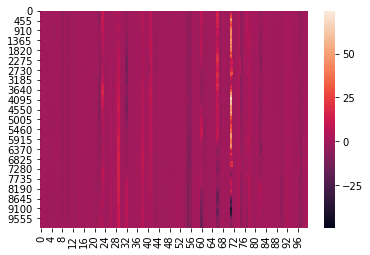

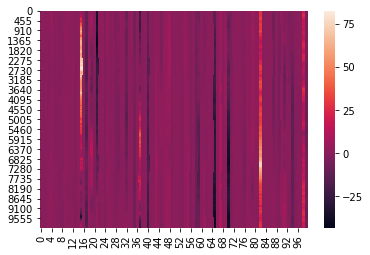

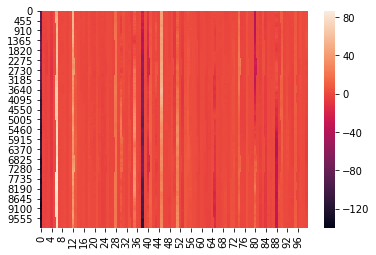

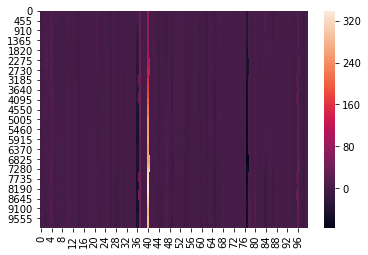

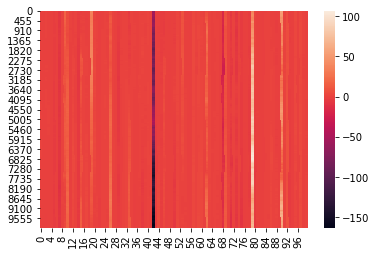

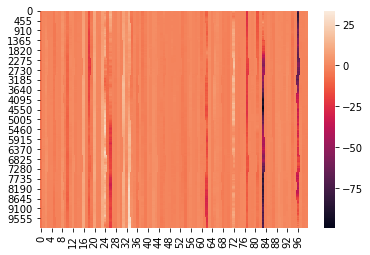

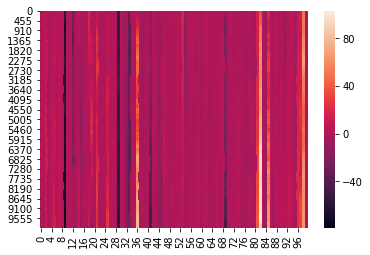

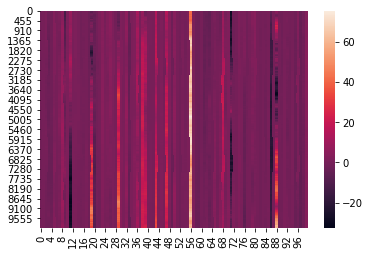

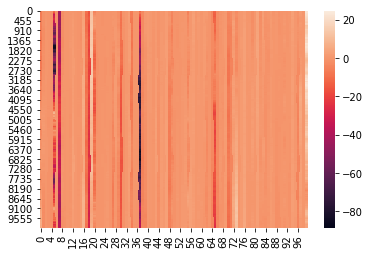

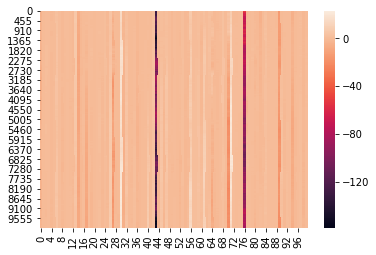

In [2]:
for i in range(10):    
    test = lemur.utils.matrix.generateRandomTimeSeries(100, 10000, strength=2)
    sns.heatmap(test)
    plt.show()

In [8]:
def inOutPlot(inVals, outVals):
    sns.distplot(inVals, kde=False, rug=True, label="intra group")
    sns.distplot(outVals, kde=False, rug=True, label="inter group")
    plt.xlabel("distance")
    plt.ylabel("frequency")
    plt.legend()
    plt.show()
    print("intra mean:", np.mean(inVals))
    print("inter mean:", np.mean(outVals))

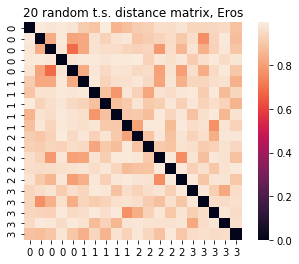

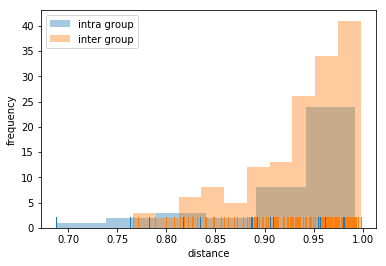

intra mean: 0.929664242467
inter mean: 0.935624540335


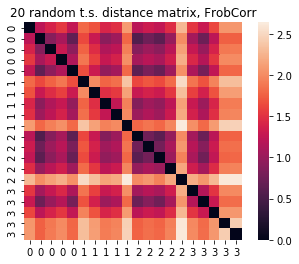

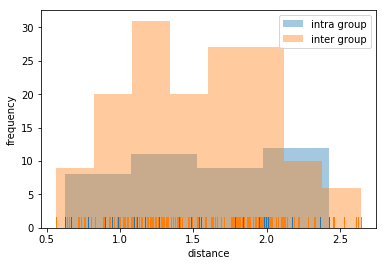

intra mean: 1.53740167586
inter mean: 1.54520636656


In [9]:
for _ in range(10):
    n_random = 20
    random_dataset = []
    for i in range(n_random):
        rts = lemur.utils.matrix.generateRandomTimeSeries(111, 10000, strength=2)
        random_dataset.append(rts)
    labels = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
    EM = lemur.distance.functions.ErosMetric(random_dataset, np.mean)
    Fr = lemur.distance.functions.FroMetric(random_dataset)
    EM_mat = lemur.distance.functions.getDistMat(EM)
    Fr_mat = lemur.distance.functions.getDistMat(Fr)
    axislabels = lemur.distance.functions.getLabels(labels, EM.N)
    EM_in, EM_out = lemur.distance.functions.distMatInnerOuter(EM_mat, labels)
    Fr_in, Fr_out = lemur.distance.functions.distMatInnerOuter(Fr_mat, labels)
    sns.heatmap(EM_mat, 
                square=True,
                xticklabels=axislabels,
                yticklabels=axislabels)
    plt.title(str(n_random) + " random t.s. distance matrix, Eros")
    plt.show()

    inOutPlot(EM_in, EM_out)

    sns.heatmap(Fr_mat,
                square=True,
                xticklabels=axislabels,
                yticklabels=axislabels)
    plt.title(str(n_random) + " random t.s. distance matrix, FrobCorr")
    plt.show()

    inOutPlot(Fr_in, Fr_out)

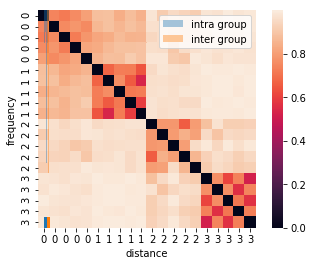

intra mean: 0.730237377267
inter mean: 0.95159939661


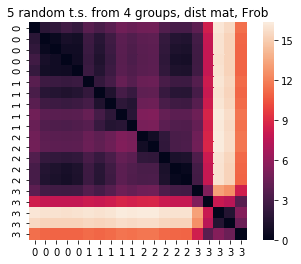

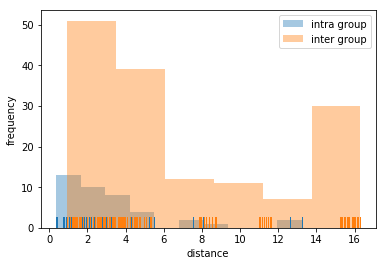

intra mean: 3.23578950517
inter mean: 7.00607957928


In [12]:
for _ in range(10):
    n_random = 5
    n_groups = 4
    groups = []
    for i in range(n_groups):
        rts = lemur.utils.matrix.generateRandomTimeSeries(
            111, n_random * 10000, strength=2)
        groups.append(rts)
    labels = []
    for i in range(n_groups):
        labels.extend([i] * n_random)
    random_dataset = []
    for g in groups:
        chunks = lemur.utils.matrix.divideMatrixIntoChunks(g, n_random)
        random_dataset.extend(chunks)
    EM = lemur.distance.functions.ErosMetric(random_dataset, np.mean)
    Fr = lemur.distance.functions.FroMetric(random_dataset)
    EM_mat = lemur.distance.functions.getDistMat(EM)
    Fr_mat = lemur.distance.functions.getDistMat(Fr)
    EM_in, EM_out = lemur.distance.functions.distMatInnerOuter(EM_mat, labels)
    Fr_in, Fr_out = lemur.distance.functions.distMatInnerOuter(Fr_mat, labels)
    axislabels = lemur.distance.functions.getLabels(labels, EM.N)

    sns.heatmap(EM_mat,
                square=True,
                xticklabels=axislabels,
                yticklabels=axislabels)
    title = "%d random t.s. from %d groups, dist mat, Eros" % (n_random, n_groups)

    inOutPlot(EM_in, EM_out)

    sns.heatmap(Fr_mat,
                square=True,
                xticklabels=axislabels,
                yticklabels=axislabels)
    title = "%d random t.s. from %d groups, dist mat, Frob" % (n_random, n_groups)
    plt.title(title)
    plt.show()

    inOutPlot(Fr_in, Fr_out)

In [6]:
subject_id = "NDARFZ296UNG"
paradigms = ["RestingState",
             #"SAIIT",
             #"SurroundSupp",
             "Video1"]#,
             #"Video2",
             #"Video3",
             #"vis_learn",
             #"WISC_ProcSpeed"]

In [8]:
datas = map(lambda x: lemur.utils.io.getData(*x),
            zip([subject_id] * len(paradigms), paradigms))
datas = zip(list(datas), paradigms)
filtered_datas= filter(lambda x: x[0] is not None, datas)
datas, labels = zip(*filtered_datas)
mc_datas = list(map(lambda x: x - np.mean(x, axis=0), datas))

In [9]:
dataset = []
for d in mc_datas:
    dataset.extend(lemur.utils.matrix.divideMatrixIntoChunks(d, 10))
full_labels = []
for l in labels:
    full_labels.extend([l] * 10)

In [10]:
EM = lemur.distance.functions.ErosMetric(dataset, np.mean)
Fr = lemur.distance.functions.FroMetric(dataset)
EM_mat = lemur.distance.functions.getDistMat(EM)
Fr_mat = lemur.distance.functions.getDistMat(Fr)
axislabels = lemur.distance.functions.getLabels(labels, EM.N)

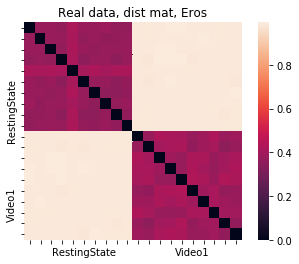

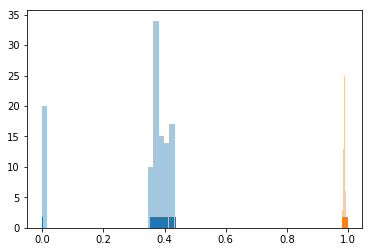

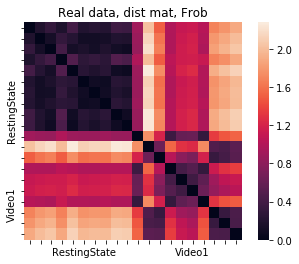

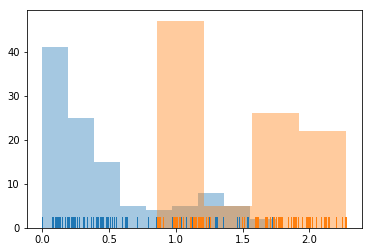

In [11]:
EM_in, EM_out = lemur.distance.functions.distMatInnerOuter(EM_mat, full_labels)
Fr_in, Fr_out = lemur.distance.functions.distMatInnerOuter(Fr_mat, full_labels)
axislabels = lemur.distance.functions.getLabels(labels, EM.N)
sns.heatmap(EM_mat, 
            square=True,
            xticklabels=axislabels,
            yticklabels=axislabels)
title = "Real data, dist mat, Eros"
plt.title(title)
plt.show()

inOutPlot(EM_in, EM_out)

sns.heatmap(Fr_mat,
            square=True,
            xticklabels=axislabels,
            yticklabels=axislabels)
title = "Real data, dist mat, Frob"
plt.title(title)
plt.show()

inOutPlot(Fr_in, Fr_out)